In [21]:
import numpy as np
import h5py
from tools.tools import *
from matplotlib import pyplot as plt 
import pandas as pd
import random as rand
from scipy.stats import zscore
import time
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.feature_selection import RFE,RFECV
import pyeeg
from nolds import hurst_rs

In [2]:
h5_datas = h5py.File("../ml_project_data/h5/X_train.h5/X_train.h5","r")
h5_features = h5py.File("../ml_project_data/h5/X_train.h5/extracted_features.hdf5","r")
labels = pd.read_csv('../ml_project_data/h5/y_train.csv').values[:,1]

In [3]:
#dirty name for train and test set 
X_train, X_test, y_train, y_test = pick_train_test(8200,labels)
eeg_train = np.transpose(record_eeg(X_train,h5_datas),(1,0,2))
eeg_test = np.transpose(record_eeg(X_test,h5_datas),(1,0,2))

In [4]:
feature_train_allan =record_features(X_train,h5_features)
feature_test_allan =record_features(X_test,h5_features)

In [5]:
treated_X_train = treat_samples_map(eeg_train,treat_record_wpt)
treated_X_test = treat_samples_map(eeg_test,treat_record_wpt)

In [6]:
pfd_train = treat_samples(eeg_train, pyeeg.pfd).T
pfd_test = treat_samples(eeg_test, pyeeg.pfd).T

In [7]:
X_train_pfd = np.concatenate((feature_train_allan,treated_X_train,pfd_train),axis=1)
X_test_pfd = np.concatenate((feature_test_allan,treated_X_test,pfd_test),axis=1)

In [22]:
hurst_train = treat_samples(eeg_train, hurst_rs).T
hurst_test = treat_samples(eeg_test, hurst_rs).T

/home/saighi/.local/lib/python3.8/site-packages/sklearn/metrics/_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [33]:
X_train_hurst = np.concatenate((X_train_pfd,hurst_train),axis=1)
X_test_hurst = np.concatenate((X_test_pfd,hurst_test),axis=1)

In [32]:
X_test_hurst.shape

(2050, 198)

# Loading RFE model from RDE CV on random tree at the end  

In [36]:
loaded_model = joblib.load("RFECV_random_forest_Allan_wpt_pfd")

In [37]:
X_train_rfe = loaded_model.transform(X_train_pfd)
X_test_rfe = loaded_model.transform(X_test_pfd)

In [41]:
X_train_hurst_rfe = np.concatenate((X_train_rfe,hurst_train),axis=1)
X_test_hurst_rfe = np.concatenate((X_test_rfe,hurst_test),axis=1)

In [11]:
X_test_rfe.shape

(2050, 74)

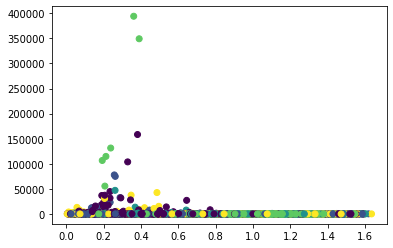

In [13]:
plt.scatter(X_train_rfe[:,0],X_train_rfe[:,1],c=y_train)

# Random Forest Classifier

In [42]:
from sklearn.ensemble import RandomForestClassifier

In [43]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train_hurst, y_train)

RandomForestClassifier()

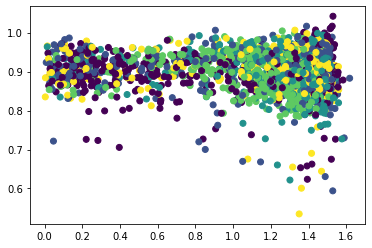

In [44]:
plt.scatter(X_test_hurst[:,0],X_test_hurst[:,-1],c=y_test)

In [45]:
f1_score(y_test,clf.predict(X_test_hurst_rfe),average="macro")

0.7642336585721802

# LightGBM

In [91]:
import lightgbm as lgb
# model = lgb.LGBMClassifier(reg_lambda=10, n_estimators=10000)
model = lgb.LGBMClassifier()
model.fit(X_train_pfd,y_train)

LGBMClassifier()

In [92]:
f1_score(y_test,model.predict(X_test_pfd),average="macro")

0.7853069679012943

In [93]:
joblib.dump(model,"lgb_Allan_wpt_pfd")

['lgb_Allan_wpt_pfd']

In [94]:
model_load = joblib.load("lgb_Allan_wpt_pfd")

In [95]:
f1_score(y_test,model_load.predict(X_test_pfd),average="macro")

0.7853069679012943

In [78]:
eeg_sub = np.transpose(record_eeg(X_test,h5_test),(1,0,2))

<KeysViewHDF5 ['eeg_1', 'eeg_2', 'eeg_3', 'eeg_4', 'eeg_5', 'eeg_6', 'eeg_7', 'index', 'index_absolute', 'index_window', 'pulse', 'x', 'y', 'z']>

In [80]:
indexes = np.array(h5_test["index_absolute"])

In [69]:
with fopen("first_sub","w")  as fsub:
    fsub.write("index,sleep_stage\n")
    
    

array([ 86,  22, 117,  73,  46,  97,  79,  59,  42,  95,   3, 110,  40,
       140,  83,  27,  59, 109,  33,  28,  75,   4,  79,  21,  75,  83,
        34,  52,  64,  25,  36,  93,   3, 106,  26,  90, 139,  32,  55,
        82,  59,  46,  83,   4,  69,  34, 106,  61,  35,  67, 102,  61,
        30,  83,   5,  65,  22, 147, 102,  40,  54, 132,  30,  36, 104,
         2,  70,  12,  64, 107,  30,  85,  67,  37,  47,  58,   5,  72,
        64, 143, 145,  62,  64, 114,  37,  54,  95,   5,  91, 106, 148,
       106, 127,  66,  48, 112, 108, 105, 143, 103, 190, 126, 137,  92,
        55,  54,  68,  77, 100, 100,  85, 127, 151, 158, 125,  38,  40,
        93, 118, 112,  90,  19, 132,  85,  41, 103,  59,  97,  91,  32,
        95,  51,  75, 112,  48,  62,  59,  16,  48,  86,  28,  64,  69,
       138,  38,  30, 100, 105,  87, 102, 118, 179,  60,  50, 144,  82,
        52,  72,  61,  76,  72,  26,  71,  58,  44, 120,  64,  86,  65,
        16,  78,  54,  76,  64,  35,  66,  48, 210, 149, 171, 19

# XGBoost

In [62]:
import xgboost as xgb

In [63]:
modelxgb = xgb.XGBClassifier()
modelxgb.fit(X_train_hurst,y_train)

/home/saighi/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:30:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [64]:
f1_score(y_test,modelxgb.predict(X_test_hurst),average="macro")

0.7764624403035463

# RFE

In [65]:
selector = RFECV(clf)

In [66]:
selector = selector.fit(X_train_pfd, y_train)

In [67]:
f1_score(y_test,selector.predict(X_test_pfd),average="macro")

0.7680276570667595

In [73]:
selector.n_features_

74

In [68]:
len(selector.ranking_)

184

In [69]:
selector.support_

array([ True, False,  True, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False,  True,
        True, False, False, False, False, False, False, False,  True,
        True,  True,  True, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
        True, False, False, False, False, False,  True,  True, False,
        True, False,  True,  True,  True,  True, False, False,  True,
        True,  True,  True, False,  True,  True,  True, False, False,
       False,  True, False,  True,  True,  True,  True,  True,  True,
       False, False, False,  True, False,  True,  True, False,  True,
        True,  True,

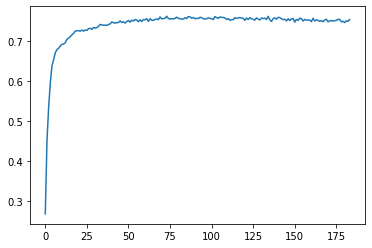

In [71]:
plt.plot(selector.grid_scores_)

In [81]:
joblib.dump(selector,"RFECV_random_forest_Allan_wpt_pfd")

['RFECV_random_forest_Allan_wpt_pfd']